Bibliotheken

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np


from model_ARIMA import grid_search_and_build_model, find_SARIMA, build_SARIMA
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test
from test_variance import goldfeldquandt_test, breuschpagan_test, koenkerbasset_test
from test_normal import hist_plot, kolmogorov_test
from time_series import seasonal_plot, seasonal_subseries_plot, acf_plot, lag_plot, decompose, arima_residuals_for_all_stores, naive_residuals_for_all_stores
from dataset import clean, features, scatter_plot, boxplot
from statsmodels.tsa.stattools import kpss


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [3]:
try:
    df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)

except FileNotFoundError:
    print("Error: File not found. Please check the file path.")

except Exception as e:
    print("An error occurred while loading the dataset:", e)


df.columns = df.columns.str.lower()

Datensatz aufräumen

In [4]:
clean(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   weekly_sales  6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB
All values in 'date' column are valid dates.
The data contains 0 duplicate values


Datensatz untersuchen

In [5]:
print(f'Der Datensatz enthält {df.shape[0]} Reihen und {df.shape[1]} Spalten')
df.describe()

Der Datensatz enthält 6435 Reihen und 8 Spalten


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


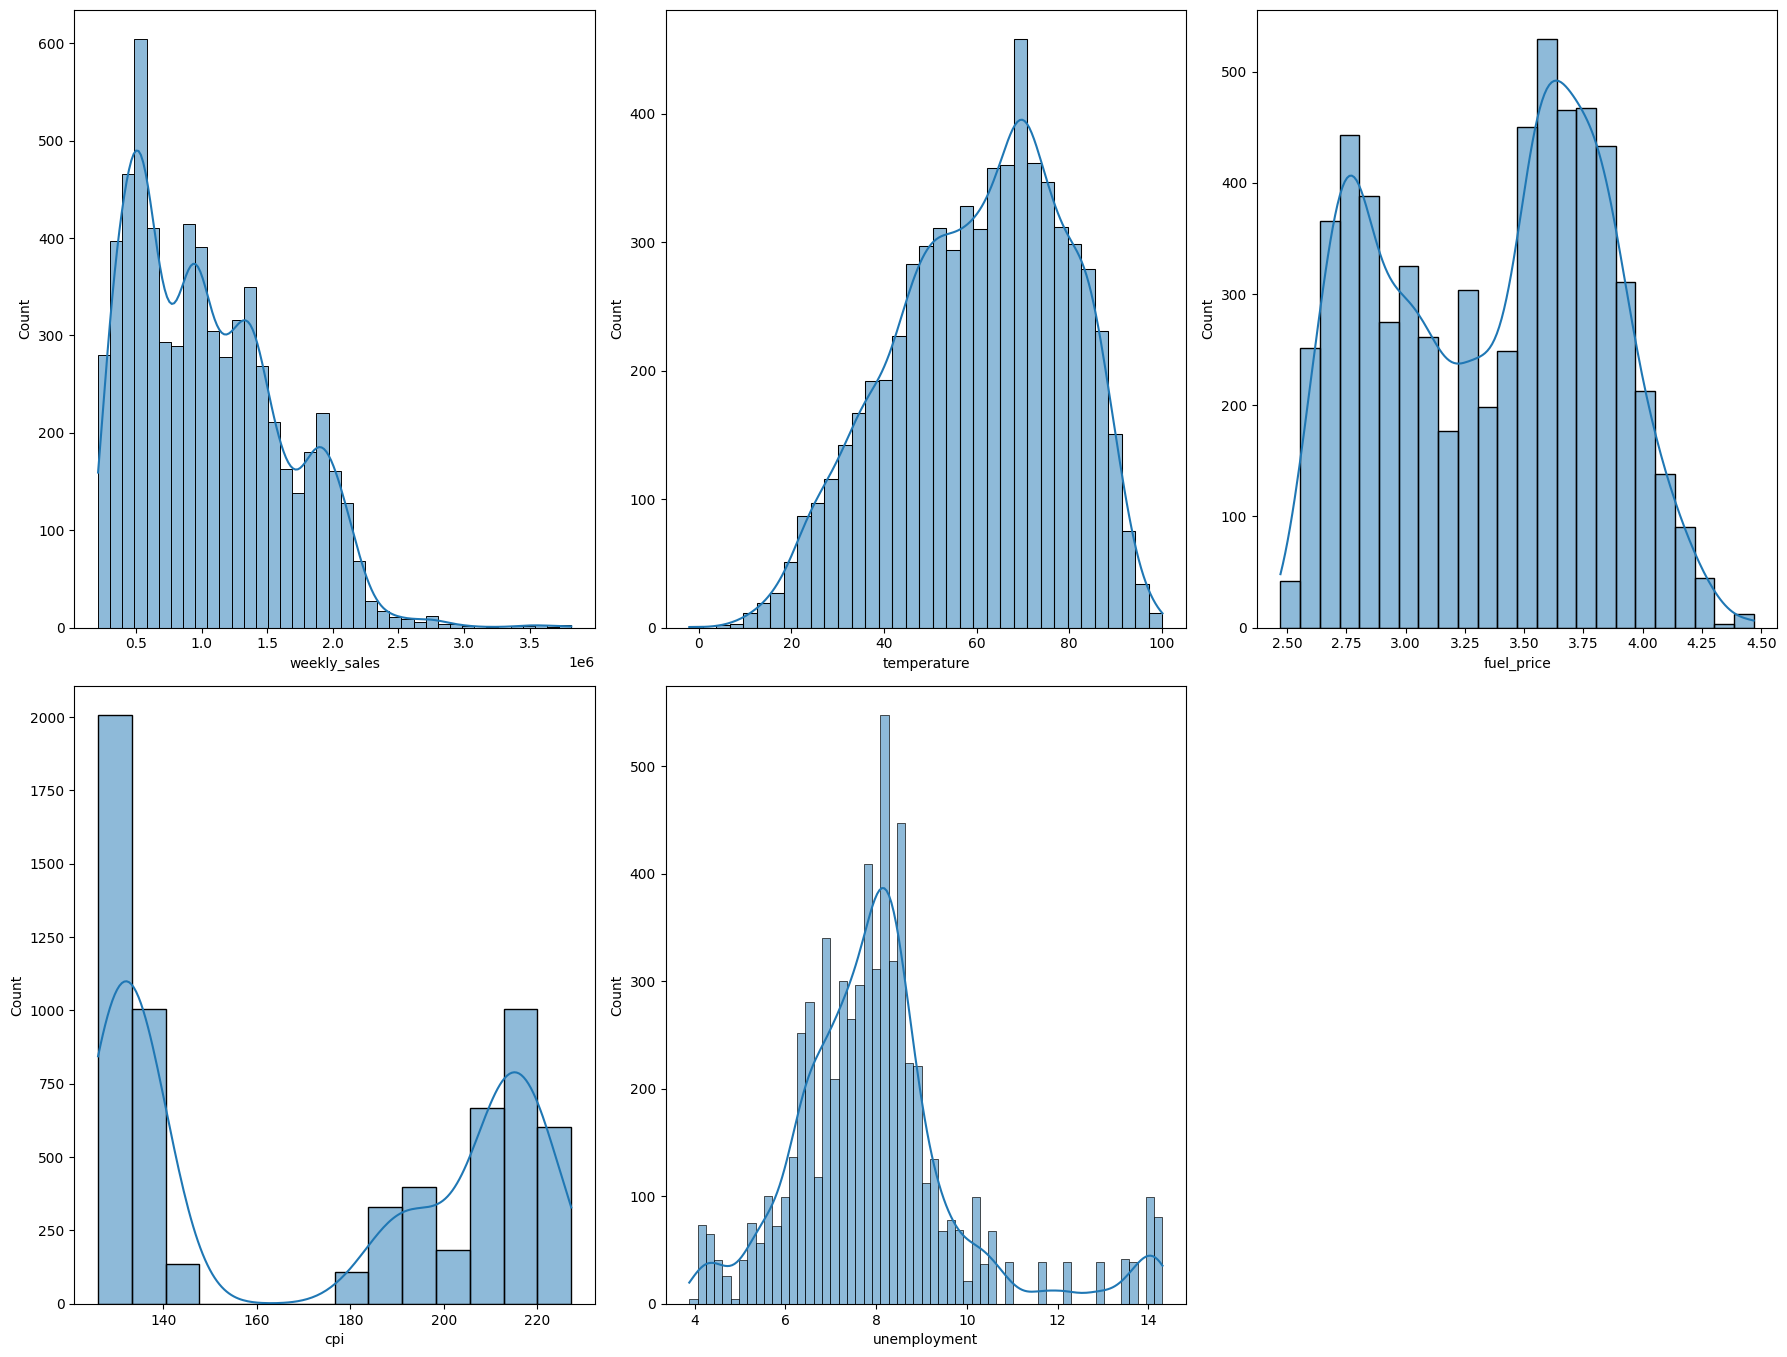

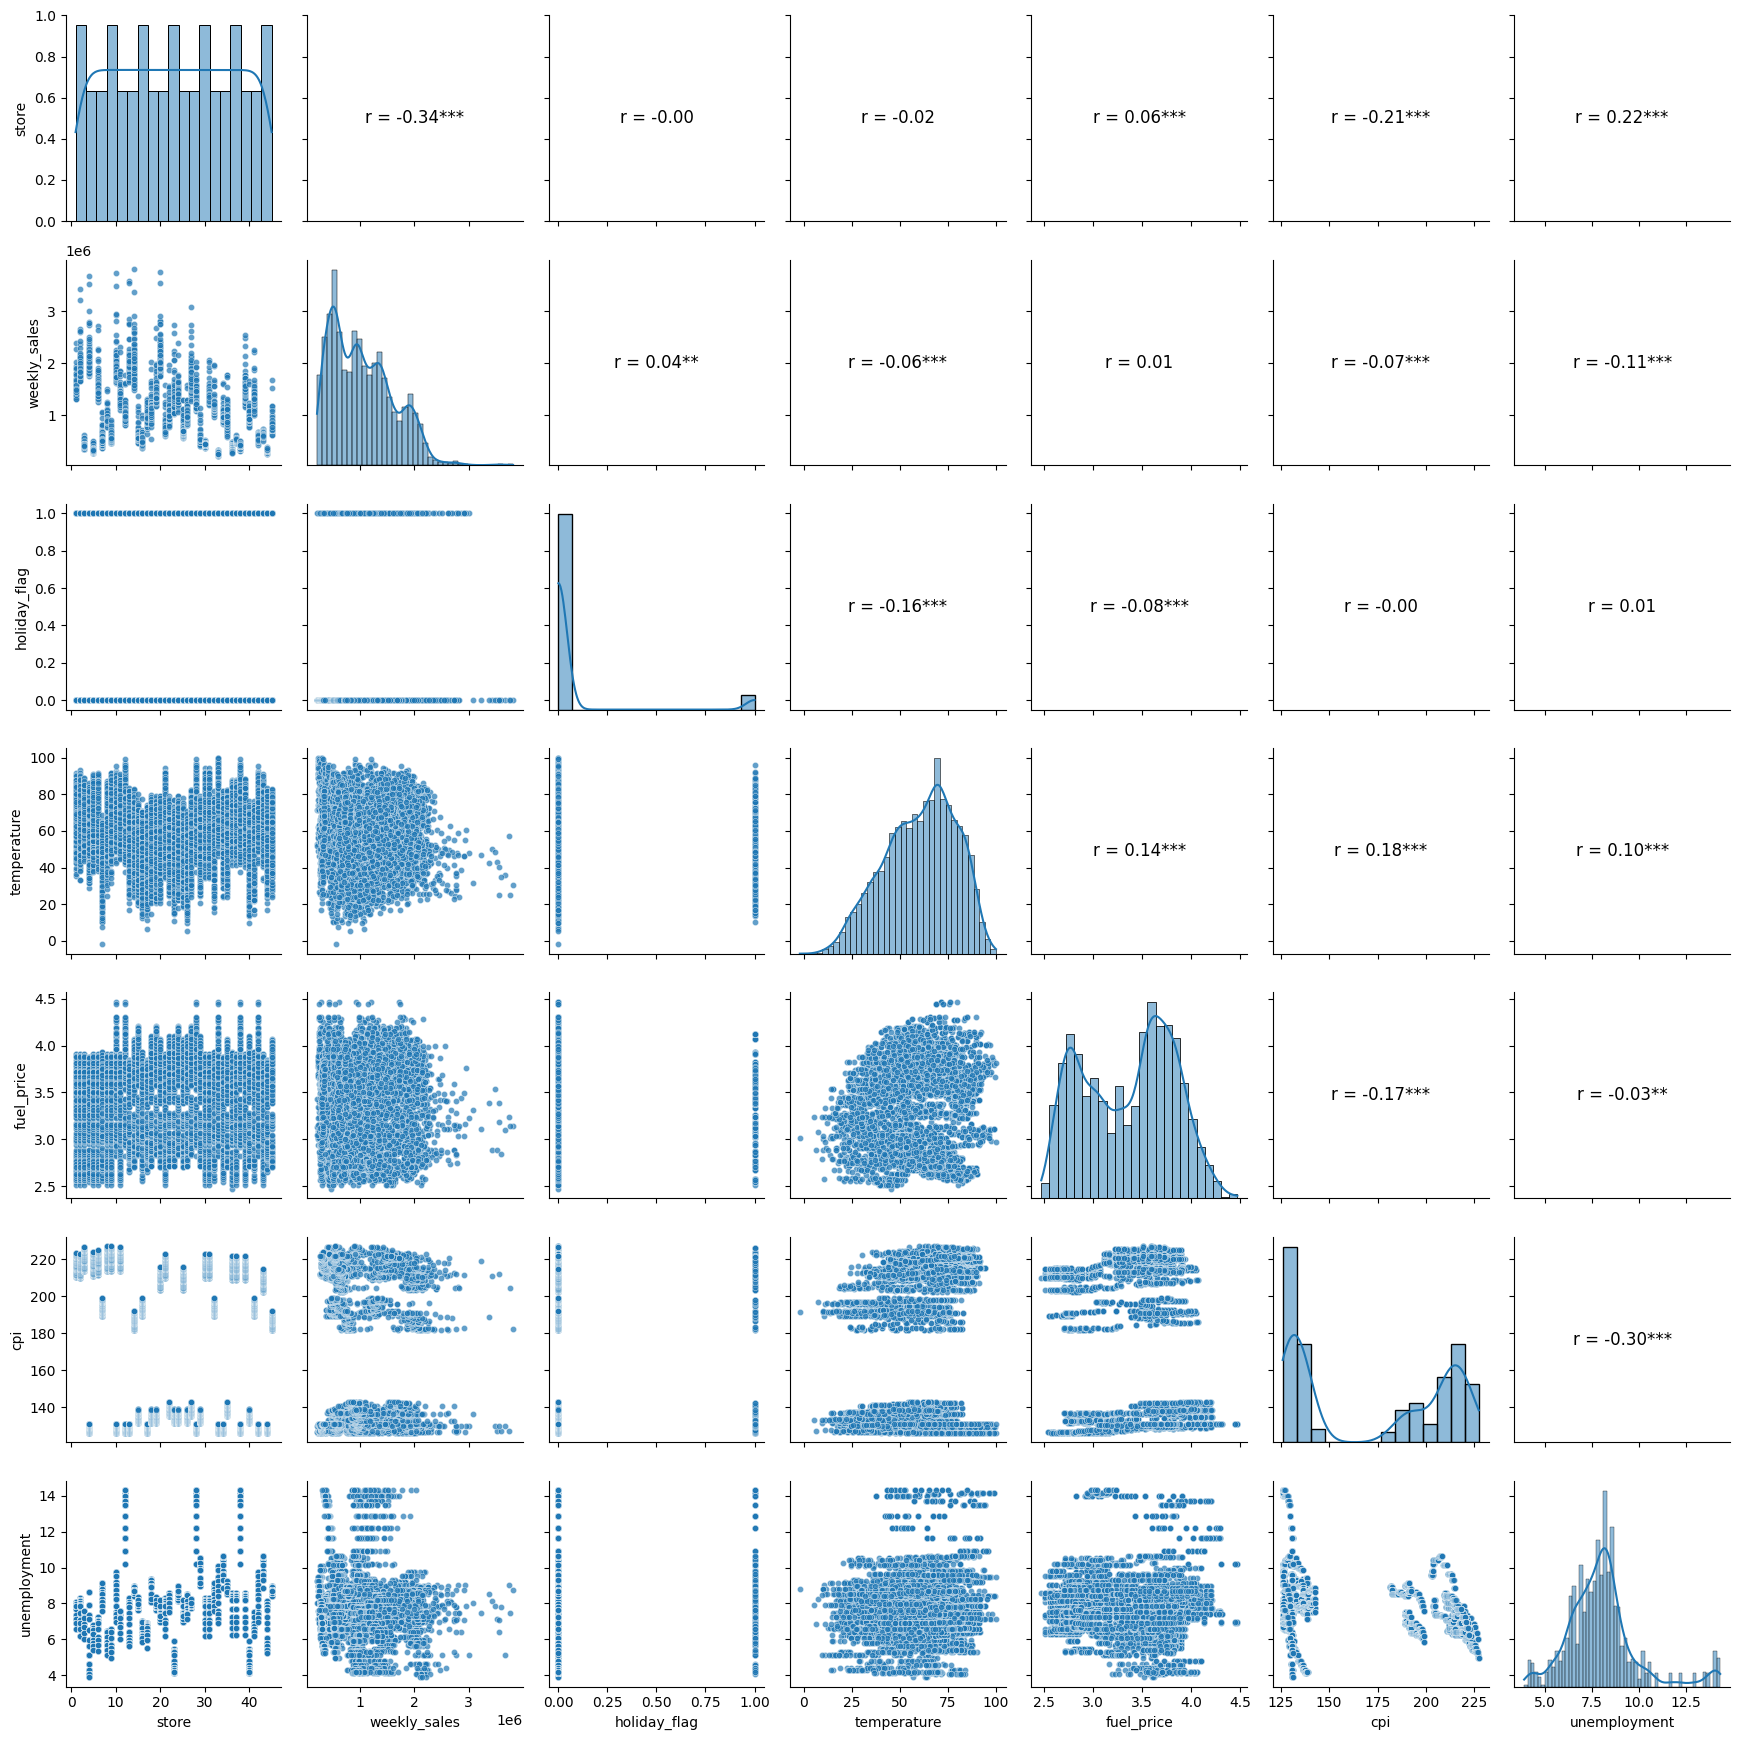

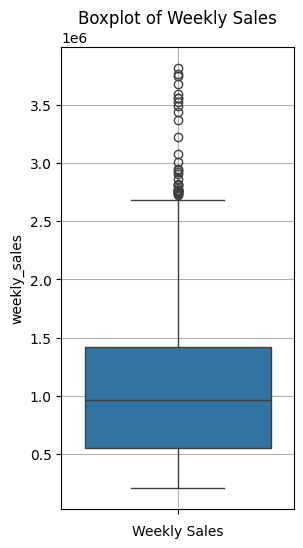

In [6]:
features(df)
scatter_plot(df)
boxplot(df)

1 Store auswählen

In [7]:
# Filtern nach Store
store_number = 1
store = df[df['store'] == store_number].copy()

# Datensatz nach Datum sortieren und als Index setzen
store.sort_values('date', inplace=True)
store.set_index('date', inplace=True)

# Nur die Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

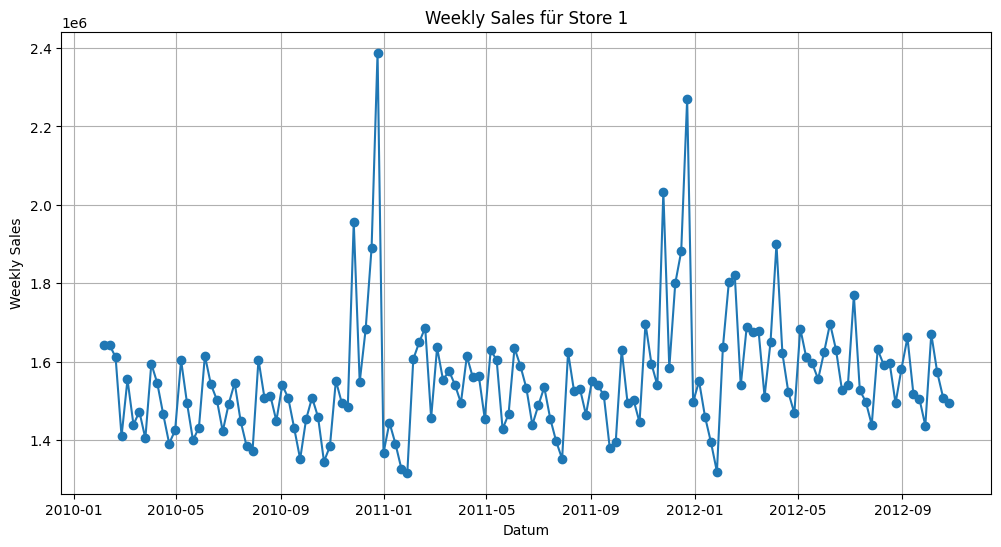

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store 1')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

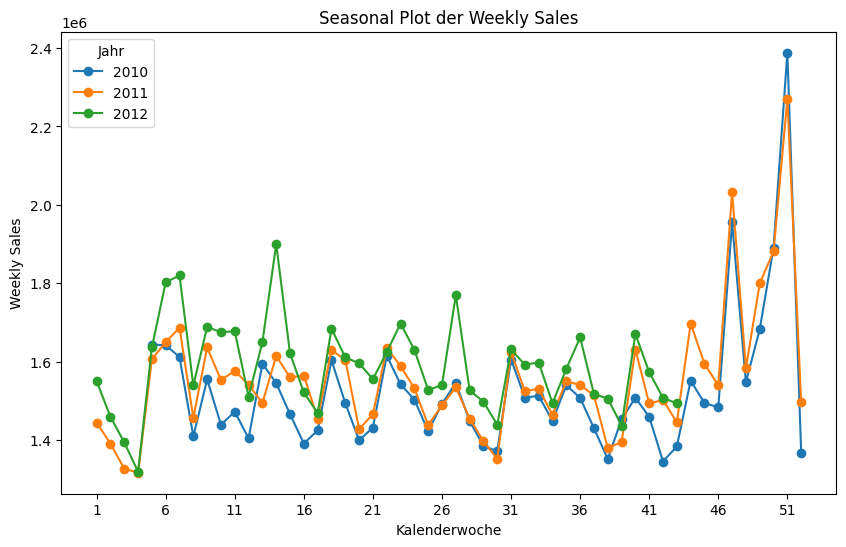

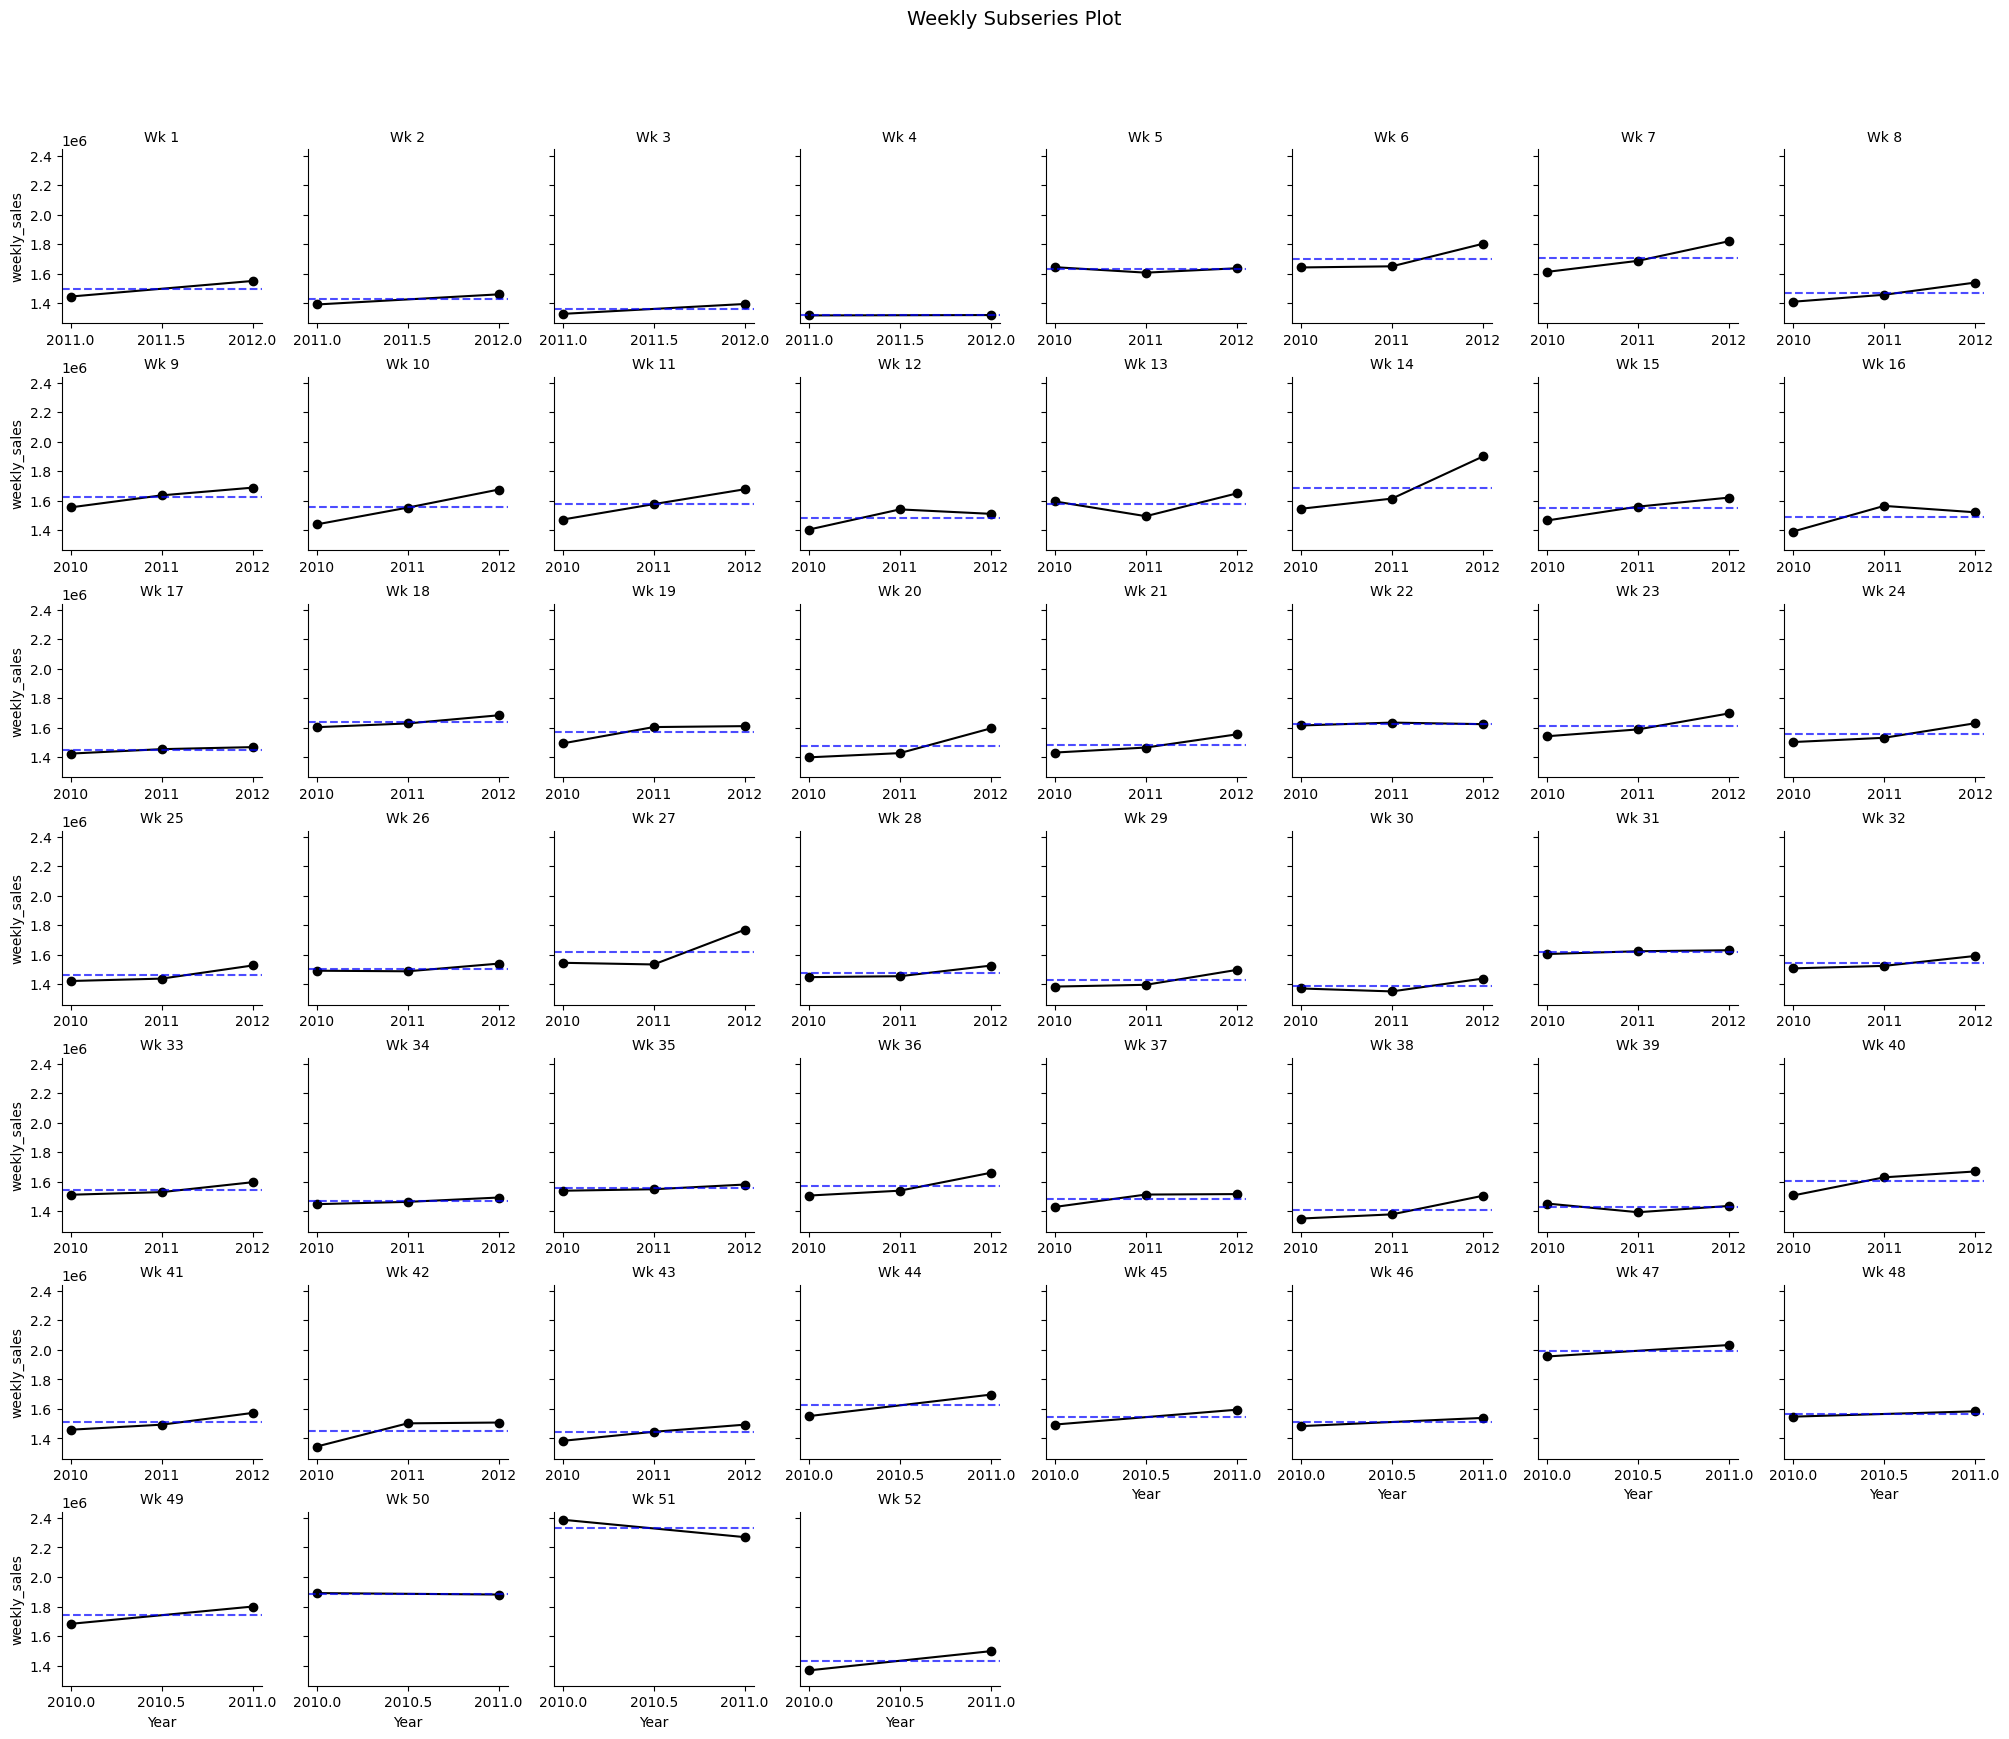

<Figure size 1200x600 with 0 Axes>

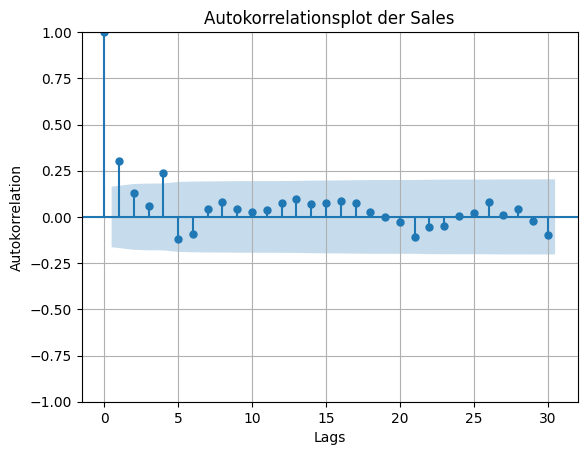

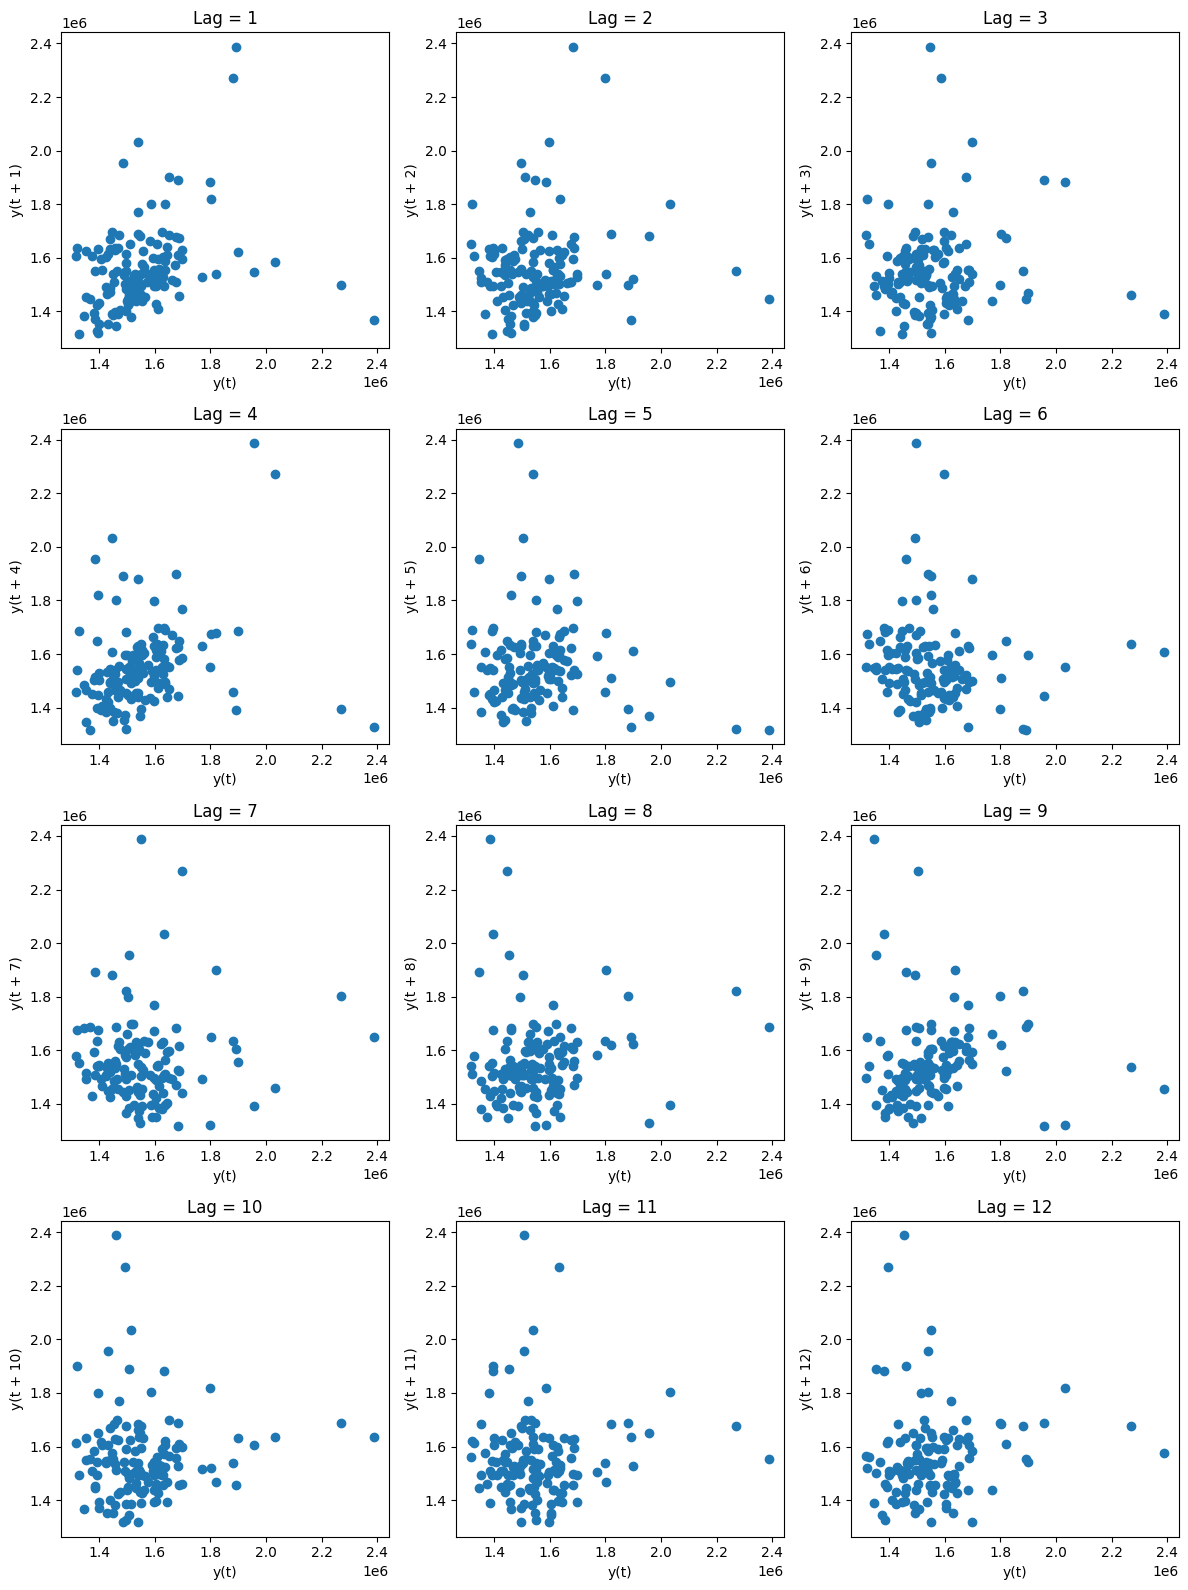

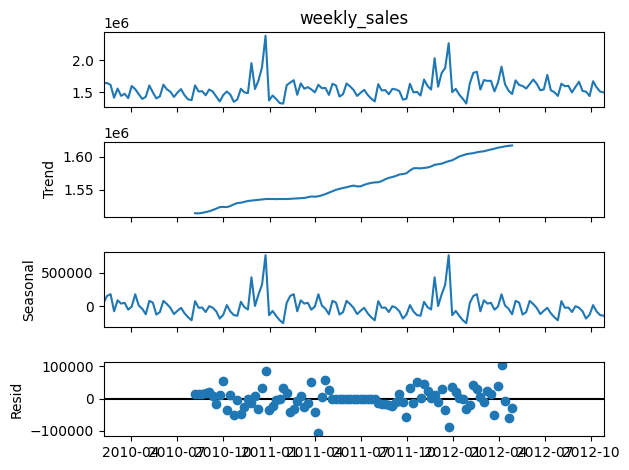

In [9]:
seasonal_plot(sales)
seasonal_subseries_plot(sales)
acf_plot(sales)
lag_plot(sales)
decompose(sales)

SARIMA

In [10]:
sarima_params = find_SARIMA(sales)
order = sarima_params.order
seasonal_order = sarima_params.seasonal_order

print(f'Optimale Parameter für SARIMA: {order}, {seasonal_order}')

sarima_model = build_SARIMA(sales, order, seasonal_order)
sarima_fitted = sarima_model.fittedvalues
sarima_resid = sales - sarima_fitted
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=3786.582, Time=2.49 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3850.005, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3795.624, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3798.433, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3848.013, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=3795.311, Time=1.68 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=3786.204, Time=1.37 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=3819.024, Time=0.06 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=3786.589, Time=24.38 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=3788.572, Time=12.70 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=3785.525, Time=2.42 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=3819.410, Time=0.09 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=inf, Time=21.82 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=3786.145, Time=2.53 sec
 ARIMA(1,1,2)(0,0,1)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        weekly_sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1884.296
Date:                             Thu, 06 Mar 2025   AIC                           3776.592
Time:                                     13:10:50   BIC                           3788.415
Sample:                                 02-05-2010   HQIC                          3781.396
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4168      0.091      4.596      0.000       0.239       0.594
ma.L1         -0.8985      0.048    -18.584      0.000      -0.993      -0.804
ar.S.L52       0.4936      0.038     12.973      0.000       0.419       0.568
sigma2      2.445e+10   3.87e-13   6.32e+22      0.000    2.44e+10    2.44e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):               155.95
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+41. Standard errors may be unstable.
"""

ARIMA Modell

In [11]:
arima_model = grid_search_and_build_model(sales)
arima_fitted = arima_model.fittedvalues
arima_resid = sales - arima_fitted
arima_model.summary()


Bestes Modell: ARIMA(2, 0, 2) mit AIC: 3802.83


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           weekly_sales   No. Observations:                  143
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1895.106
Date:                Thu, 06 Mar 2025   AIC                           3802.213
Time:                        13:10:51   BIC                           3819.990
Sample:                    02-05-2010   HQIC                          3809.437
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.555e+06   1.98e+04     78.529      0.000    1.52e+06    1.59e+06
ar.L1         -0.9335      0.127     -7.323      0.000      -1.183      -0.684
ar.L2         -0.3905      0.114     -3.438      0.001      -0.613      -0.168
ma.L1          1.3429      0.087     15.475      0.000       1.173       1.513
ma.L2          0.8680      0.072     11.977      0.000       0.726       1.010
sigma2        2.1e+10      0.136   1.54e+11      0.000     2.1e+10     2.1e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               111.23
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.40
Prob(H) (two-sided):                  0.39   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+26. Standard errors may be unstable.
"""

Naives Modell

In [12]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Aussuchen

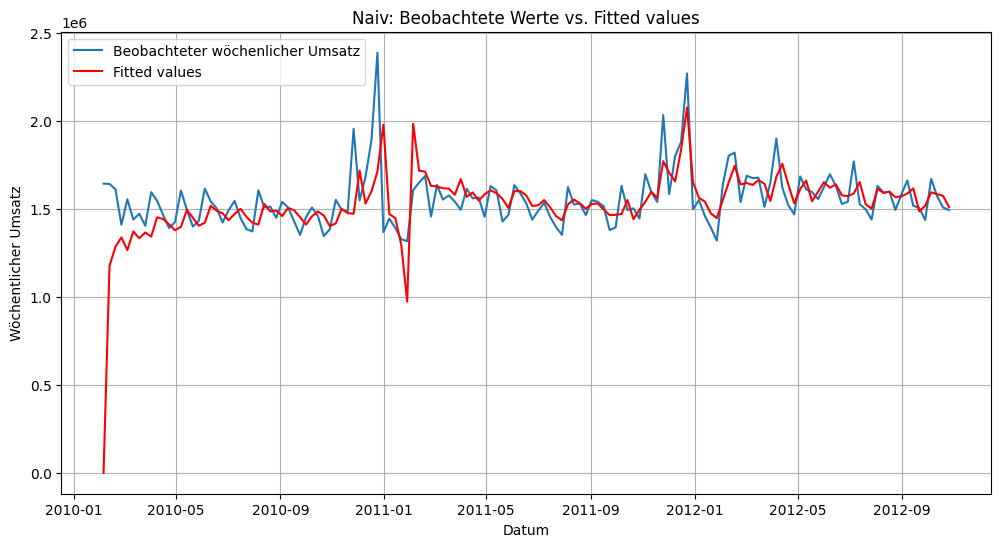

In [13]:
#residuen = naiv_resid
#fitted_values = naiv_fitted
residuen = arima_resid
fitted_values = arima_fitted
residuen = sarima_resid
fitted_values = sarima_fitted


plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted values')
plt.title('Naiv: Beobachtete Werte vs. Fitted values')
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Tests

Mittelwert der Residuen: 26122.4148


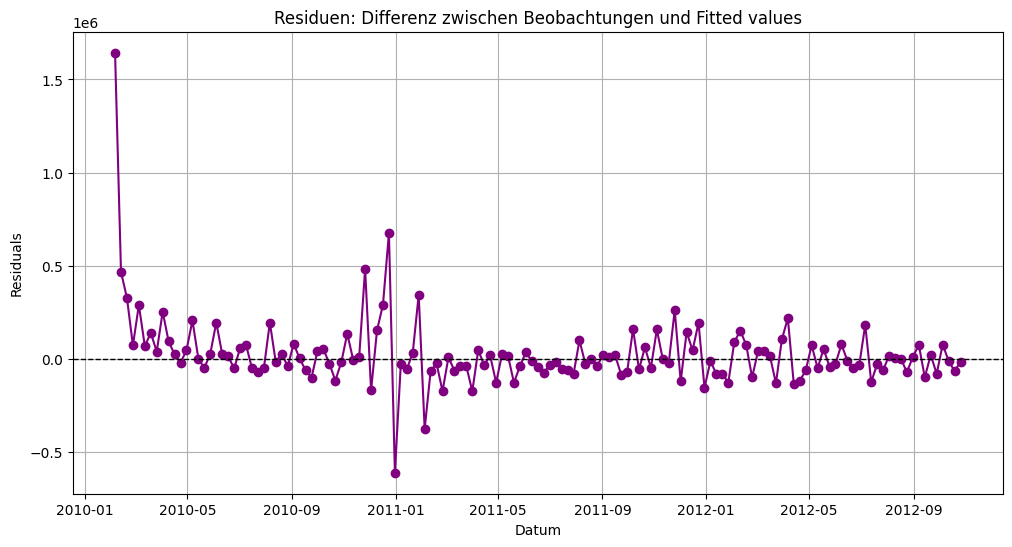

<Figure size 1200x600 with 0 Axes>

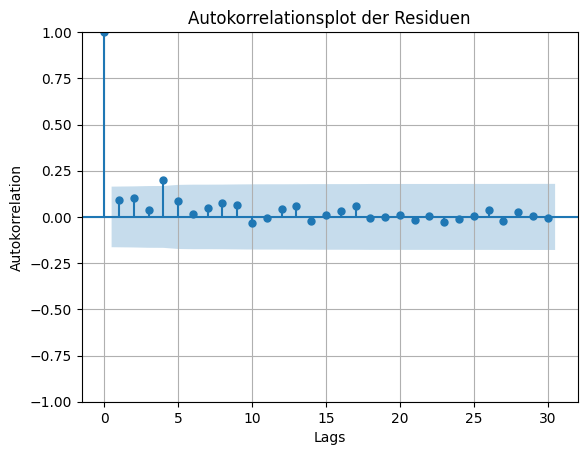

Box Pierce: 0.3150


In [14]:
mean_resid = residuen.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")
residual_plot(residuen)
acf_resid_plot(residuen)
bp_stat, bp_pvalue = box_pierce_test(residuen)
print(f"Box Pierce: {bp_pvalue:.4f}")

Alle Residuen berechnen

In [15]:
#residuals_dict = arima_residuals_for_all_stores('Walmart_Sales.csv')
residuals_dict = naive_residuals_for_all_stores('Walmart_Sales.csv')

Correlation Tests

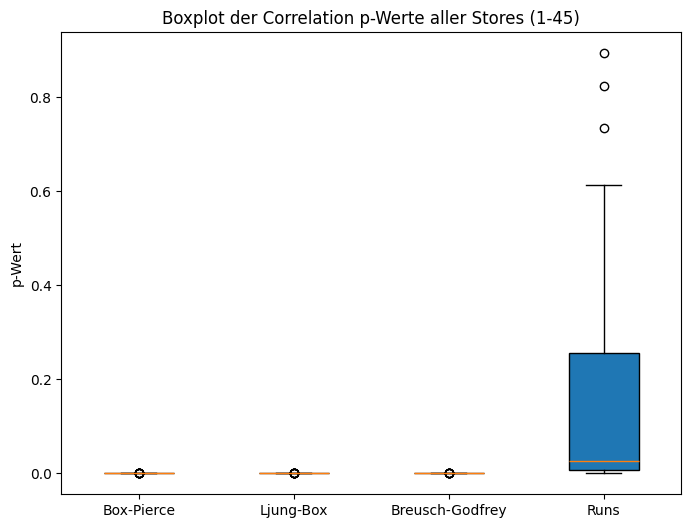

[8.689786487014075e-09, 4.133855850884368e-09, 6.454160417589576e-07, 2.6583387846543576e-09, 1.0687655913593197e-07, 1.4234852122184982e-06, 1.9842791954287418e-05, 1.5546712020116287e-09, 8.371299316120333e-09, 5.550888639790784e-08, 3.0493663618997136e-08, 4.892323185670045e-10, 3.857493036977332e-10, 7.553938887010481e-11, 4.543359788628094e-08, 2.9082527041951697e-05, 1.578526358871021e-11, 6.371654115256078e-10, 4.567406095520707e-06, 3.141826185046233e-07, 5.3397682568869416e-08, 2.1502863287386094e-10, 4.663161257347384e-05, 2.8979538464966485e-07, 7.18155205698773e-06, 2.3683779524959077e-10, 2.3092288087493548e-09, 1.3646328154583973e-14, 2.0719146848850333e-09, 3.949423231732605e-15, 8.918863190729794e-13, 6.634553205286917e-12, 1.966659238385877e-52, 1.2757294865884778e-10, 1.5262076054624033e-10, 3.3266173381915303e-25, 8.475050828302933e-10, 3.952562241598255e-21, 5.3535379585512615e-11, 7.436201509801058e-10, 1.8538087031739804e-13, 6.96476369550316e-60, 4.61779396295241

In [16]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(resid, lags=[10])
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(resid, lags=[10])
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(resid, lags=10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(resid)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Correlation p-Werte aller Stores (1-45)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs"])
plt.show()

print(bp_pvalues)

Durbin Watson

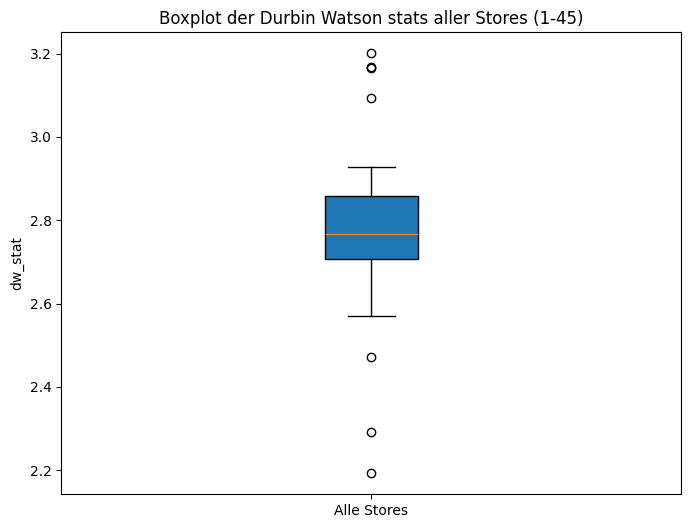

[2.751232724925425, 2.7679447550960545, 2.70794711930034, 2.785954482119405, 2.8281949211677166, 2.6705925589858923, 2.616043094128576, 2.7767684966688173, 2.741654827376988, 2.709379399298398, 2.6680632956972574, 2.7734108637181603, 2.7631084426875634, 2.8773077654428936, 2.7014165476572822, 2.57087593075364, 3.1671557163023154, 2.816966813470863, 2.727106429174113, 2.732035743534923, 2.6021977462988954, 2.750065871348965, 2.5810996319577315, 2.7767705525747073, 2.604333651603585, 2.8671831010976816, 2.863457649629558, 2.926705965071621, 2.73579171129304, 3.0937292639611074, 2.8654135999410557, 2.829917186659994, 2.2925891410451347, 2.8574772734764293, 2.8124180885849728, 2.4721788388293398, 3.1658762958583155, 2.8588288548431855, 2.7885958497164007, 2.9087658869321933, 2.9016429818382057, 2.1924237175987815, 2.7069372210805516, 3.2008885492647647, 2.7376521072094158]


In [17]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True)
plt.title("Boxplot der Durbin Watson stats aller Stores (1-45)")
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(dw_stats)

Mittelwert Tests

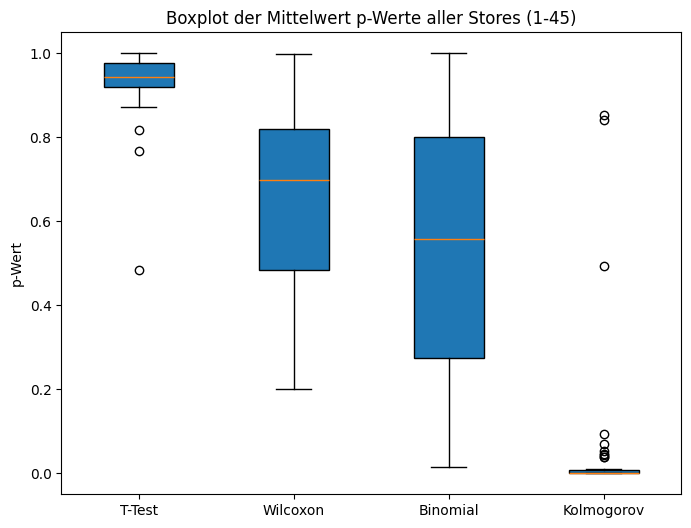

In [18]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Mittelwert p-Werte aller Stores (1-45)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()

